# CF_movie_recommendation_using_KNN

https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-1-knn-item-based-collaborative-filtering-637969614ea

## Overview

In this project, I will build an item-based collaborative filtering system using [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/). Specically, I will train a KNN models to cluster similar movies based on user's ratings and make movie recommendation based on similarity score of previous rated movies. 


## [Recommender system](https://en.wikipedia.org/wiki/Recommender_system)
A recommendation system is basically an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. It is widely used in different internet / online business such as Amazon, Netflix, Spotify, or social media like Facebook and Youtube. By using recommender systems, those companies are able to provide better or more suited products/services/contents that are personalized to a user based on his/her historical consumer behaviors

Recommender systems typically produce a list of recommendations through collaborative filtering or through content-based filtering

This project will focus on collaborative filtering and use item-based collaborative filtering systems make movie recommendation


## [Item-based Collaborative Filtering](https://beckernick.github.io/music_recommender/)
Collaborative filtering based systems use the actions of users to recommend other items. In general, they can either be user based or item based. User based collaborating filtering uses the patterns of users similar to me to recommend a product (users like me also looked at these other items). Item based collaborative filtering uses the patterns of users who browsed the same item as me to recommend me a product (users who looked at my item also looked at these other items). Item-based approach is usually prefered than user-based approach. User-based approach is often harder to scale because of the dynamic nature of users, whereas items usually don't change much, so item-based approach often can be computed offline.


## Data Sets
I use [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/).
This dataset (ml-latest.zip) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 27753444 ratings and 1108997 tag applications across 58098 movies. These data were created by 283228 users between January 09, 1995 and September 26, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 1 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`.

## Project Content
1. Load data
2. Exploratory data analysis
3. Train KNN model for item-based collaborative filtering
4. Use this trained model to make movie recommendations to myself
5. Deep dive into the bottleneck of item-based collaborative filtering.
 - cold start problem
 - data sparsity problem
 - popular bias (how to recommend products from the tail of product distribution)
 - scalability bottleneck
6. Further study

In [3]:
!pip install fuzzywuzzy

In [4]:
import os
import time

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [5]:
# path config
#data_path = os.path.join(os.environ['DATA_PATH'], 'MovieLens')
movies_filename = '/content/drive/My Drive/Data/Movie dataset/movies_metadata.csv'
ratings_filename = '/content/drive/My Drive/Data/Movie dataset/ratings.csv'

## 1. Load Data

In [7]:
 pd.read_csv(
    movies_filename)

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.9469,/rhIRbceoE9lR4veEXuwCC2wARtG.jpg,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,17.0155,/vzmL6fP7aPKNKPRTFnZmiUfciyV.jpg,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129,/6ksm1sjKMFLbO7UY2i6G1ju9SML.jpg,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.85949,/16XOMpEaLWkrcPqSQqhTmeJuqQl.jpg,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.38752,/e64sOI48hQXyru7naBFyssKFxVd.jpg,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45461,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...",http://www.imdb.com/title/tt6209470/,439050,tt6209470,fa,رگ خواب,Rising and falling between a man and woman.,0.072051,/jldsYflnId4tTWPx8es3uzsB1I8.jpg,[],"[{'iso_3166_1': 'IR', 'name': 'Iran'}]",NaN,0.0,90.0,"[{'iso_639_1': 'fa', 'name': 'فارسی'}]",Released,Rising and falling between a man and woman,Subdue,False,4.0,1.0
45462,False,NaN,0,"[{'id': 18, 'name': 'Drama'}]",NaN,111109,tt2028550,tl,Siglo ng Pagluluwal,An artist struggles to finish his work while a...,0.178241,/xZkmxsNmYXJbKVsTRLLx3pqGHx7.jpg,"[{'name': 'Sine Olivia', 'id': 19653}]","[{'iso_3166_1': 'PH', 'name': 'Philippines'}]",2011-11-17,0.0,360.0,"[{'iso_639_1': 'tl', 'name': ''}]",Released,NaN,Century of Birthing,False,9.0,3.0
45463,False,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",NaN,67758,tt0303758,en,Betrayal,"When one of her hits goes wrong, a professiona...",0.903007,/d5bX92nDsISNhu3ZT69uHwmfCGw.jpg,"[{'name': 'American World Pictures', 'id': 6165}]","[{'iso_3166_1': 'US', 'name': 'United States o...",2003-08-01,0.0,90.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,A deadly game of wits.,Betrayal,False,3.8,6.0
45464,Fa

In [9]:
df_movies = pd.read_csv(
    movies_filename,
    usecols=['id', 'title'],
    #dtype={'id': 'int32', 'title': 'str'}
    )
df_movies.columns=['movieId','title']

In [12]:
df_ratings = pd.read_csv(
    ratings_filename,
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'}
    )

In [10]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45466 entries, 0 to 45465
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  45466 non-null  object
 1   title    45460 non-null  object
dtypes: object(2)
memory usage: 710.5+ KB


In [13]:
df_ratings.info() 
# ram decrease from 595 mb to 297 mb, because change int64 --> int 32, float 64 --> float 32

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26024289 entries, 0 to 26024288
Data columns (total 3 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int32  
 1   movieId  int32  
 2   rating   float32
dtypes: float32(1), int32(2)
memory usage: 297.8 MB


In [14]:
df_movies.head()

,movieId,title
0,862,Toy Story
1,8844,Jumanji
2,15602,Grumpier Old Men
3,31357,Waiting to Exhale
4,11862,Father of the Bride Part II


In [15]:
df_ratings.head()

,userId,movieId,rating
0,1,110,1.0
1,1,147,4.5
2,1,858,5.0
3,1,1221,5.0
4,1,1246,5.0


In [16]:
num_users = len(df_ratings.userId.unique())
num_items = len(df_ratings.movieId.unique())
print('There are {} unique users and {} unique movies in this data set'.format(num_users, num_items))

There are 270896 unique users and 45115 unique movies in this data set


## 2. Exploratory data analysis
 - Plot the counts of each rating
 - Plot rating frequency of each movie

#### 1. Plot the counts of each rating

we first need to get the counts of each rating from ratings data

In [17]:
# get count
df_ratings_cnt_tmp = pd.DataFrame(df_ratings.groupby('rating').size(), columns=['count'])
df_ratings_cnt_tmp

,count
rating,
0.5,404897
1.0,843310
1.5,403607
2.0,1762440
2.5,1255358
3.0,5256722
3.5,3116213
4.0,6998802
4.5,2170441


We can see that above table does not include counts of zero rating score. So we need to add that in rating count dataframe as well

In [18]:
# there are a lot more counts in rating of zero
total_cnt = num_users * num_items
rating_zero_cnt = total_cnt - df_ratings.shape[0]
# append counts of zero rating to df_ratings_cnt
df_ratings_cnt = df_ratings_cnt_tmp.append(
    pd.DataFrame({'count': rating_zero_cnt}, index=[0.0]),
    verify_integrity=True,
).sort_index()
df_ratings_cnt

,count
0.0,12195448751
0.5,404897
1.0,843310
1.5,403607
2.0,1762440
2.5,1255358
3.0,5256722
3.5,3116213
4.0,6998802
4.5,2170441


The count for zero rating score is too big to compare with others. So let's take log transform for count values and then we can plot them to compare

In [ ]:
# add log count
df_ratings_cnt['log_count'] = np.log(df_ratings_cnt['count'])
df_ratings_cnt

,count,log_count
0.0,15235120248,23.446869
0.5,442388,12.999943
1.0,886233,13.694735
1.5,441354,12.997603
2.0,1850627,14.431035
2.5,1373419,14.132814
3.0,5515668,15.523103
3.5,3404360,15.040568
4.0,7394710,15.816275
4.5,2373550,14.679897


Text(0, 0.5, 'number of ratings')

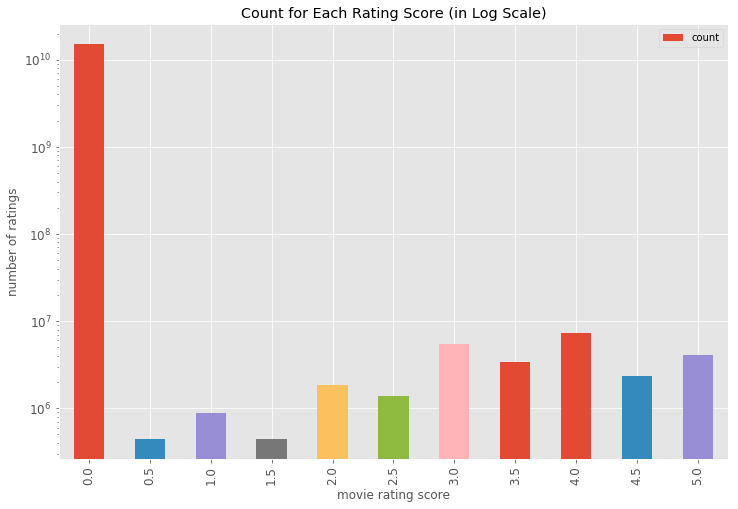

In [ ]:
ax = df_ratings_cnt[['count']].reset_index().rename(columns={'index': 'rating score'}).plot(
    x='rating score',
    y='count',
    kind='bar',
    figsize=(12, 8),
    title='Count for Each Rating Score (in Log Scale)',
    logy=True,
    fontsize=12,
)
ax.set_xlabel("movie rating score")
ax.set_ylabel("number of ratings")

It's interesting that there are more people giving rating score of 3 and 4 than other scores 

#### 2. Plot rating frequency of all movies

In [ ]:
df_ratings.head()

,userId,movieId,rating
0,1,307,3.5
1,1,481,3.5
2,1,1091,1.5
3,1,1257,4.5
4,1,1449,4.5


In [ ]:
# get rating frequency
df_movies_cnt = pd.DataFrame(df_ratings.groupby('movieId').size(), columns=['count'])
df_movies_cnt.head()

,count
movieId,
1,68469
2,27143
3,15585
4,2989
5,15474


Text(0, 0.5, 'number of ratings')

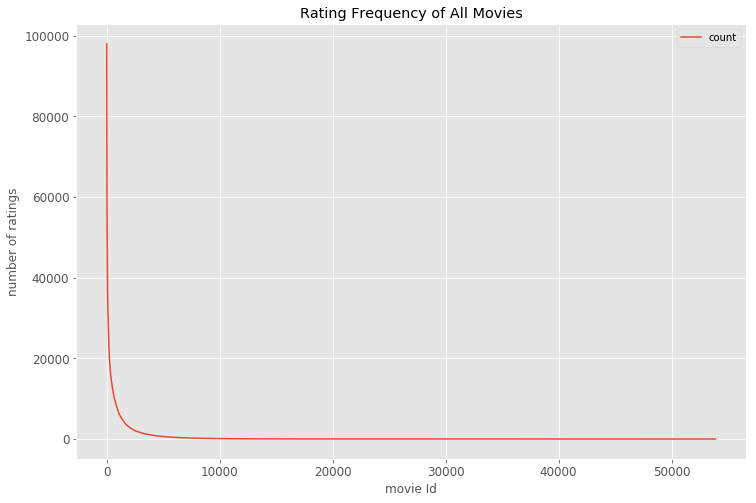

In [ ]:
# plot rating frequency of all movies
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies',
        fontsize=12
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings")

The distribution of ratings among movies often satisfies a property in real-world settings,
which is referred to as the long-tail property. According to this property, only a small
fraction of the items are rated frequently. Such items are referred to as popular items. The
vast majority of items are rated rarely. This results in a highly skewed distribution of the
underlying ratings.

Let's plot the same distribution but with log scale

Text(0, 0.5, 'number of ratings (log scale)')

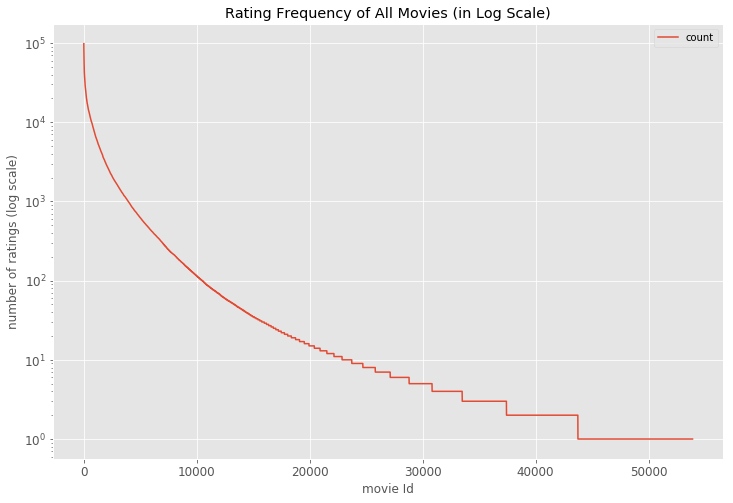

In [ ]:
# plot rating frequency of all movies in log scale
ax = df_movies_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Movies (in Log Scale)',
        fontsize=12,
        logy=True
    )
ax.set_xlabel("movie Id")
ax.set_ylabel("number of ratings (log scale)")

We can see that roughly 10,000 out of 53,889 movies are rated more than 100 times. More interestingly, roughly 20,000 out of 53,889 movies are rated less than only 10 times. Let's look closer by displaying top quantiles of rating counts

In [ ]:
df_movies_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    97999.0
0.95     1855.0
0.90      531.0
0.85      205.0
0.80       91.0
0.75       48.0
0.70       28.0
0.65       18.0
Name: count, dtype: float64

So about 1% of movies have roughly 97,999 or more ratings, 5% have 1,855 or more, and 20% have 100 or more. Since we have so many movies, we'll limit it to the top 25%. This is arbitrary threshold for popularity, but it gives us about 13,500 different movies. We still have pretty good amount of movies for modeling. There are two reasons why we want to filter to roughly 13,500 movies in our dataset.
 - Memory issue: we don't want to run into the “MemoryError” during model training
 - Improve KNN performance: lesser known movies have ratings from fewer viewers, making the pattern more noisy. Droping out less known movies can improve recommendation quality

In [ ]:
# filter data
popularity_thres = 50
popular_movies = list(set(df_movies_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_movies = df_ratings[df_ratings.movieId.isin(popular_movies)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular movies: ', df_ratings_drop_movies.shape)

shape of original ratings data:  (27753444, 3)
shape of ratings data after dropping unpopular movies:  (27430748, 3)


After dropping 75% of movies in our dataset, we still have a very large dataset. So next we can filter users to further reduce the size of data

In [ ]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_movies.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,16
2,15
3,11
4,736
5,72


Text(0, 0.5, 'number of ratings')

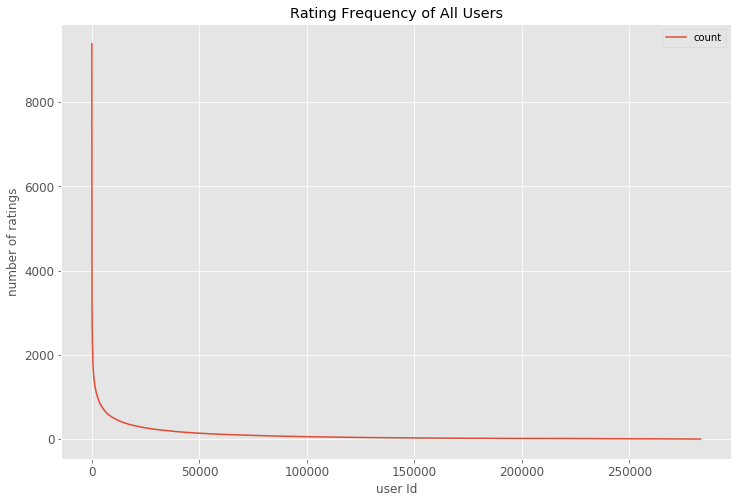

In [ ]:
# plot rating frequency of all movies
ax = df_users_cnt \
    .sort_values('count', ascending=False) \
    .reset_index(drop=True) \
    .plot(
        figsize=(12, 8),
        title='Rating Frequency of All Users',
        fontsize=12
    )
ax.set_xlabel("user Id")
ax.set_ylabel("number of ratings")

In [ ]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    9384.0
0.95     403.0
0.90     239.0
0.85     164.0
0.80     121.0
0.75      94.0
0.70      73.0
0.65      58.0
0.60      47.0
0.55      37.0
Name: count, dtype: float64

We can see that the distribution of ratings by users is very similar to the distribution of ratings among movies. They both have long-tail property. Only a very small fraction of users are very actively engaged with rating movies that they watched. Vast majority of users aren't interested in rating movies. So we can limit users to the top 40%, which is about 113,291 users.

In [ ]:
# filter data
ratings_thres = 50
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_movies[df_ratings_drop_movies.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular movies and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (27753444, 3)
shape of ratings data after dropping both unpopular movies and inactive users:  (24178982, 3)


## 3. Train KNN model for item-based collaborative filtering
 - Reshaping the Data
 - Fitting the Model

#### 1. Reshaping the Data
For K-Nearest Neighbors, we want the data to be in an (artist, user) array, where each row is a movie and each column is a different user. To reshape the dataframe, we'll pivot the dataframe to the wide format with movies as rows and users as columns. Then we'll fill the missing observations with 0s since we're going to be performing linear algebra operations (calculating distances between vectors). Finally, we transform the values of the dataframe into a scipy sparse matrix for more efficient calculations.

In [ ]:
# pivot and create movie-user matrix
movie_user_mat = df_ratings_drop_users.pivot(index='movieId', columns='userId', values='rating').fillna(0)
# create mapper from movie title to index
movie_to_idx = {
    movie: i for i, movie in 
    enumerate(list(df_movies.set_index('movieId').loc[movie_user_mat.index].title))
}
# transform matrix to scipy sparse matrix
movie_user_mat_sparse = csr_matrix(movie_user_mat.values)

#### 2. Fitting the Model
Time to implement the model. We'll initialize the NearestNeighbors class as model_knn and fit our sparse matrix to the instance. By specifying the metric = cosine, the model will measure similarity bectween artist vectors by using cosine similarity.

In [ ]:
%env JOBLIB_TEMP_FOLDER=/tmp
# define model
model_knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
# fit
model_knn.fit(movie_user_mat_sparse)

env: JOBLIB_TEMP_FOLDER=/tmp


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
         metric_params=None, n_jobs=-1, n_neighbors=20, p=2, radius=1.0)

## 4. Use this trained model to make movie recommendations to myself
And we're finally ready to make some recommendations!

In [ ]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(model_knn, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    model_knn.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [ ]:
my_favorite = 'Iron Man'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)

You have input movie: Iron Man
Found possible matches in our database: ['Iron Man (2008)', 'Iron Man 3 (2013)', 'Iron Man 2 (2010)']

Recommendation system start to make inference
......

Recommendations for Iron Man:
1: Bourne Ultimatum, The (2007), with distance of 0.4217848777770996
2: Sherlock Holmes (2009), with distance of 0.4190899133682251
3: Inception (2010), with distance of 0.39293038845062256
4: Avatar (2009), with distance of 0.38322633504867554
5: WALL·E (2008), with distance of 0.38314002752304077
6: Star Trek (2009), with distance of 0.37503182888031006
7: Batman Begins (2005), with distance of 0.3701704144477844
8: Iron Man 2 (2010), with distance of 0.37011009454727173
9: Avengers, The (2012), with distance of 0.3579972982406616
10: Dark Knight, The (2008), with distance of 0.3010351061820984


This is very interesting that my **KNN** model recommends movies that were also produced in very similar years. However, the cosine distance of all those recommendations are actually quite small. This is probabily because there is too many zero values in our movie-user matrix. With too many zero values in our data, the data sparsity becomes a real issue for **KNN** model and the distance in **KNN** model starts to fall apart. So I'd like to dig deeper and look closer inside our data.

#### (extra inspection) 
Let's now look at how sparse the movie-user matrix is by calculating percentage of zero values in the data.

In [ ]:
# calcuate total number of entries in the movie-user matrix
num_entries = movie_user_mat.shape[0] * movie_user_mat.shape[1]
# calculate total number of entries with zero values
num_zeros = (movie_user_mat==0).sum(axis=1).sum()
# calculate ratio of number of zeros to number of entries
ratio_zeros = num_zeros / num_entries
print('There is about {:.2%} of ratings in our data is missing'.format(ratio_zeros))

There is about 98.35% of ratings in our data is missing


This result confirms my hypothesis. The vast majority of entries in our data is zero. This explains why the distance between similar items or opposite items are both pretty large.

## 5. Deep dive into the bottleneck of item-based collaborative filtering.
 - cold start problem
 - data sparsity problem
 - popular bias (how to recommend products from the tail of product distribution)
 - scalability bottleneck

We saw there is 98.35% of user-movie interactions are not yet recorded, even after I filtered out less-known movies and inactive users. Apparently, we don't even have sufficient information for the system to make reliable inferences for users or items. This is called **Cold Start** problem in recommender system.

There are three cases of cold start:

1. New community: refers to the start-up of the recommender, when, although a catalogue of items might exist, almost no users are present and the lack of user interaction makes very hard to provide reliable recommendations
2. New item: a new item is added to the system, it might have some content information but no interactions are present
3. New user: a new user registers and has not provided any interaction yet, therefore it is not possible to provide personalized recommendations

We are not concerned with the last one because we can use item-based filtering to make recommendations for new user. In our case, we are more concerned with the first two cases, especially the second case.

The item cold-start problem refers to when items added to the catalogue have either none or very little interactions. This constitutes a problem mainly for collaborative filtering algorithms due to the fact that they rely on the item's interactions to make recommendations. If no interactions are available then a pure collaborative algorithm cannot recommend the item. In case only a few interactions are available, although a collaborative algorithm will be able to recommend it, the quality of those recommendations will be poor. This arises another issue, which is not anymore related to new items, but rather to unpopular items. In some cases (e.g. movie recommendations) it might happen that a handful of items receive an extremely high number of iteractions, while most of the items only receive a fraction of them. This is also referred to as popularity bias. Please recall previous long-tail skewed distribution of movie rating frequency plot.

In addtition to that, scalability is also a big issue in KNN model too. Its time complexity is O(nd + kn), where n is the cardinality of the training set and d the dimension of each sample. And KNN takes more time in making inference than training, which increase the prediction latency

## 6. Further study

Use spark's ALS to solve above problems

#CF_movie_recommendation_using_ALS

https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1

## Overview

In this project, I will use an Alternating Least Squares (ALS) algorithm with Spark APIs to predict the ratings for the movies in [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/)

## [Recommender system](https://en.wikipedia.org/wiki/Recommender_system)
A recommendation system is basically an information filtering system that seeks to predict the "rating" or "preference" a user would give to an item. It is widely used in different internet / online business such as Amazon, Netflix, Spotify, or social media like Facebook and Youtube. By using recommender systems, those companies are able to provide better or more suited products/services/contents that are personalized to a user based on his/her historical consumer behaviors

Recommender systems typically produce a list of recommendations through collaborative filtering or through content-based filtering

This project will focus on collaborative filtering and use Alternating Least Squares (ALS) algorithm to make movie predictions


## [Alternating Least Squares](https://endymecy.gitbooks.io/spark-ml-source-analysis/content/%E6%8E%A8%E8%8D%90/papers/Large-scale%20Parallel%20Collaborative%20Filtering%20the%20Netflix%20Prize.pdf)
ALS is one of the low rank matrix approximation algorithms for collaborative filtering. ALS decomposes user-item matrix into two low rank matrixes: user matrix and item matrix. In collaborative filtering, users and products are described by a small set of latent factors that can be used to predict missing entries. And ALS algorithm learns these latent factors by matrix factorization


## Data Sets
I use [MovieLens Datasets](https://grouplens.org/datasets/movielens/latest/).
This dataset (ml-latest.zip) describes 5-star rating and free-text tagging activity from [MovieLens](http://movielens.org), a movie recommendation service. It contains 27753444 ratings and 1108997 tag applications across 58098 movies. These data were created by 283228 users between January 09, 1995 and September 26, 2018. This dataset was generated on September 26, 2018.

Users were selected at random for inclusion. All selected users had rated at least 1 movies. No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in the files `genome-scores.csv`, `genome-tags.csv`, `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`.

## Project Content
1. Load Data
2. Spark SQL and OLAP
3. Spark ALS based approach for training model
4. ALS Model Selection and Evaluation
5. Model testing
6. Make movie recommendation to myself

In [ ]:
import os
import time

# spark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import UserDefinedFunction, explode, desc
from pyspark.sql.types import StringType, ArrayType
from pyspark.mllib.recommendation import ALS

# data science imports
import math
import numpy as np
import pandas as pd

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
# spark config
spark = SparkSession \
    .builder \
    .appName("movie recommendation") \
    .config("spark.driver.maxResultSize", "96g") \
    .config("spark.driver.memory", "96g") \
    .config("spark.executor.memory", "8g") \
    .config("spark.master", "local[12]") \
    .getOrCreate()
# get spark context
sc = spark.sparkContext

In [ ]:
# path config
data_path = os.path.join(os.environ['DATA_PATH'], 'MovieLens')

## Load Data

In [ ]:
movies = spark.read.load(os.path.join(data_path, 'movies.csv'), format='csv', header=True, inferSchema=True)
ratings = spark.read.load(os.path.join(data_path, 'ratings.csv'), format='csv', header=True, inferSchema=True)
links = spark.read.load(os.path.join(data_path, 'links.csv'), format='csv', header=True, inferSchema=True)
tags = spark.read.load(os.path.join(data_path, 'tags.csv'), format='csv', header=True, inferSchema=True)

### basic inspection

In [ ]:
movies.show(3)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
+-------+--------------------+--------------------+
only showing top 3 rows



In [ ]:
ratings.show(3)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    307|   3.5|1256677221|
|     1|    481|   3.5|1256677456|
|     1|   1091|   1.5|1256677471|
+------+-------+------+----------+
only showing top 3 rows



In [ ]:
links.show(3)

+-------+------+------+
|movieId|imdbId|tmdbId|
+-------+------+------+
|      1|114709|   862|
|      2|113497|  8844|
|      3|113228| 15602|
+-------+------+------+
only showing top 3 rows



In [ ]:
tags.show(3)

+------+-------+--------+----------+
|userId|movieId|     tag| timestamp|
+------+-------+--------+----------+
|    14|    110|    epic|1443148538|
|    14|    110|Medieval|1443148532|
|    14|    260|  sci-fi|1442169410|
+------+-------+--------+----------+
only showing top 3 rows



## Spark SQL and OLAP

Below are the questions I'd like to ask:
1. What are the ratings?
2. What is minimum number of ratings per user and minimum number of ratings per movie?
3. How many movies are rated by only one user?
4. What is the total number of users in the data sets?
5. What is the total number of movies in the data sets?
6. How many movies are rated by users? List movies not rated yet?
7. List all movie genres
8. Find out the number of movies for each category
9. Calculate the total rating count for every movie
10. Get a count plot for each rating

What are the ratings?

In [ ]:
print('Distinct values of ratings:')
print(sorted(ratings.select('rating').distinct().rdd.map(lambda r: r[0]).collect()))

Distinct values of ratings:
[0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


What is minimum number of ratings per user and minimum number of ratings per movie?

In [ ]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 1
Minimum number of ratings per movie is 1


How many movies are rated by only one user?

In [ ]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

10155 out of 53889 movies are rated by only one user


What is the total number of users in the data sets?

In [ ]:
tmp = ratings.select('userID').distinct().count()
print('We have a total of {} distinct users in the data sets'.format(tmp))

We have a total of 283228 distinct users in the data sets


What is the total number of movies in the data sets?

In [ ]:
tmp = movies.select('movieID').distinct().count()
print('We have a total of {} distinct movies in the data sets'.format(tmp))

We have a total of 58098 distinct movies in the data sets


How many movies are rated by users? List movies not rated yet?

In [ ]:
tmp1 = movies.select('movieID').distinct().count()
tmp2 = ratings.select('movieID').distinct().count()
print('We have a total of {} distinct movies that are rated by users in ratings table'.format(tmp2))
print('We have {} movies that are not rated yet'.format(tmp1-tmp2))

We have a total of 53889 distinct movies that are rated by users in ratings table
We have 4209 movies that are not rated yet


In [ ]:
# create a temp SQL table view for easier query
movies.createOrReplaceTempView("movies")
ratings.createOrReplaceTempView("ratings")
print('List movies that are not rated yet: ')
# SQL query (NOTE: WHERE ... NOT IN ... == ... LEFT JOIN ... WHERE ... IS NULL)
# Approach 1
spark.sql(
    "SELECT movieId, title "
    "FROM movies "
    "WHERE movieId NOT IN (SELECT distinct(movieId) FROM ratings)"
).show(10)
# Approach 2
# spark.sql(
#     "SELECT m.movieId, m.title "
#     "FROM movies m LEFT JOIN ratings r ON m.movieId=r.movieId "
#     "WHERE r.movieId IS NULL"
# ).show(10)

List movies that are not rated yet: 
+-------+--------------------+
|movieId|               title|
+-------+--------------------+
|  25817|Break of Hearts (...|
|  26361|Baby Blue Marine ...|
|  27153|Can't Be Heaven (...|
|  27433|        Bark! (2002)|
|  31945|Always a Bridesma...|
|  52696|Thousand and One ...|
|  58209|Alex in Wonder (S...|
|  60234|   Shock, The (1923)|
|  69565|Bling: A Planet R...|
|  69834|       Agency (1980)|
+-------+--------------------+
only showing top 10 rows



List all movie genres

In [ ]:
# define a udf for splitting the genres string
splitter = UserDefinedFunction(lambda x: x.split('|'), ArrayType(StringType()))
# query
print('All distinct genres: ')
movies.select(explode(splitter("genres")).alias("genres")).distinct().show()

All distinct genres: 
+------------------+
|            genres|
+------------------+
|             Crime|
|           Romance|
|          Thriller|
|         Adventure|
|             Drama|
|               War|
|       Documentary|
|           Fantasy|
|           Mystery|
|           Musical|
|         Animation|
|         Film-Noir|
|(no genres listed)|
|              IMAX|
|            Horror|
|           Western|
|            Comedy|
|          Children|
|            Action|
|            Sci-Fi|
+------------------+



Find out the number of movies for each category

In [ ]:
print('Counts of movies per genre')
movies.select('movieID', explode(splitter("genres")).alias("genres")) \
    .groupby('genres') \
    .count() \
    .sort(desc('count')) \
    .show()

Counts of movies per genre
+------------------+-----+
|            genres|count|
+------------------+-----+
|             Drama|24144|
|            Comedy|15956|
|          Thriller| 8216|
|           Romance| 7412|
|            Action| 7130|
|            Horror| 5555|
|       Documentary| 5118|
|             Crime| 5105|
|(no genres listed)| 4266|
|         Adventure| 4067|
|            Sci-Fi| 3444|
|           Mystery| 2773|
|          Children| 2749|
|         Animation| 2663|
|           Fantasy| 2637|
|               War| 1820|
|           Western| 1378|
|           Musical| 1113|
|         Film-Noir|  364|
|              IMAX|  197|
+------------------+-----+



## Spark ALS based approach for training model
1. Reload data
2. Split data into train, validation, test
3. ALS model selection and evaluation
4. Model testing

### Reload data
We will use an RDD-based API from pyspark.mllib to predict the ratings, so let's reload "ratings.csv" using sc.textFile and then convert it to the form of (user, item, rating) tuples.

In [ ]:
# load data
movie_rating = sc.textFile(os.path.join(data_path, 'ratings.csv'))
# preprocess data -- only need ["userId", "movieId", "rating"]
header = movie_rating.take(1)[0]
rating_data = movie_rating \
    .filter(lambda line: line!=header) \
    .map(lambda line: line.split(",")) \
    .map(lambda tokens: (int(tokens[0]), int(tokens[1]), float(tokens[2]))) \
    .cache()
# check three rows
rating_data.take(3)

[(1, 307, 3.5), (1, 481, 3.5), (1, 1091, 1.5)]

### Split data
Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [ ]:
train, validation, test = rating_data.randomSplit([6, 2, 2], seed=99)
# cache data
train.cache()
validation.cache()
test.cache()

PythonRDD[166] at RDD at PythonRDD.scala:52

### ALS model selection and evaluation
With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [ ]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    """
    Grid Search Function to select the best model based on RMSE of hold-out data
    """
    # initial
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # train ALS model
            model = ALS.train(
                ratings=train_data,    # (userID, productID, rating) tuple
                iterations=num_iters,
                rank=rank,
                lambda_=reg,           # regularization param
                seed=99)
            # make prediction
            valid_data = validation_data.map(lambda p: (p[0], p[1]))
            predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
            # get the rating result
            ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
            # get the RMSE
            MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
            error = math.sqrt(MSE)
            print('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model

In [ ]:
# hyper-param config
num_iterations = 10
ranks = [8, 10, 12, 14, 16, 18, 20]
reg_params = [0.001, 0.01, 0.05, 0.1, 0.2]

# grid search and select best model
start_time = time.time()
final_model = train_ALS(train, validation, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

8 latent factors and regularization = 0.001: validation RMSE is 0.8786891340427128
8 latent factors and regularization = 0.01: validation RMSE is 0.8505897623504987
8 latent factors and regularization = 0.05: validation RMSE is 0.8180916431113182
8 latent factors and regularization = 0.1: validation RMSE is 0.8191175872308086
8 latent factors and regularization = 0.2: validation RMSE is 0.8649215618478324
10 latent factors and regularization = 0.001: validation RMSE is 0.8881965019270155
10 latent factors and regularization = 0.01: validation RMSE is 0.8549168385580616
10 latent factors and regularization = 0.05: validation RMSE is 0.8175174972199897
10 latent factors and regularization = 0.1: validation RMSE is 0.8196465380445364
10 latent factors and regularization = 0.2: validation RMSE is 0.8654977750796198
12 latent factors and regularization = 0.001: validation RMSE is 0.9003310016924109
12 latent factors and regularization = 0.01: validation RMSE is 0.8639878306627452
12 latent 

### ALS model learning curve
As we increase number of iterations in training ALS, we can see how RMSE changes and whether or not model is overfitted.

In [ ]:
def plot_learning_curve(arr_iters, train_data, validation_data, reg, rank):
    """
    Plot function to show learning curve of ALS
    """
    errors = []
    for num_iters in arr_iters:
        # train ALS model
        model = ALS.train(
            ratings=train_data,    # (userID, productID, rating) tuple
            iterations=num_iters,
            rank=rank,
            lambda_=reg,           # regularization param
            seed=99)
        # make prediction
        valid_data = validation_data.map(lambda p: (p[0], p[1]))
        predictions = model.predictAll(valid_data).map(lambda r: ((r[0], r[1]), r[2]))
        # get the rating result
        ratesAndPreds = validation_data.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
        # get the RMSE
        MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
        error = math.sqrt(MSE)
        # add to errors
        errors.append(error)

    # plot
    plt.figure(figsize=(12, 6))
    plt.plot(arr_iters, errors)
    plt.xlabel('number of iterations')
    plt.ylabel('RMSE')
    plt.title('ALS Learning Curve')
    plt.grid(True)
    plt.show()

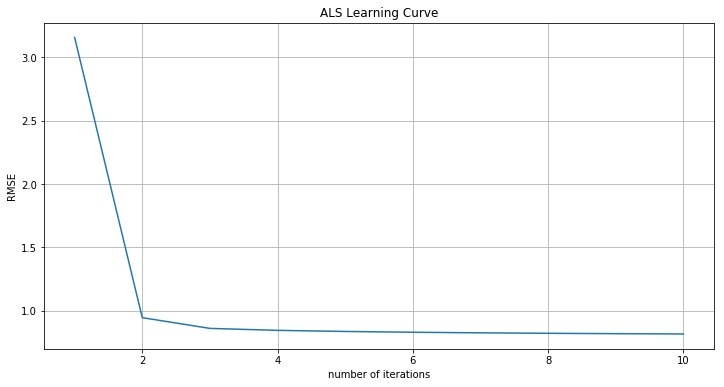

In [ ]:
# create an array of num_iters
iter_array = list(range(1, 11))
# create learning curve plot
plot_learning_curve(iter_array, train, validation, 0.05, 20)

After 3 iterations, alternating gradient descend starts to converge at an error around 0.8

### Model testing
And finally, make a prediction and check the testing error using out-of-sample data

In [ ]:
# make prediction using test data
test_data = test.map(lambda p: (p[0], p[1]))
predictions = final_model.predictAll(test_data).map(lambda r: ((r[0], r[1]), r[2]))
# get the rating result
ratesAndPreds = test.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
# get the RMSE
MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
error = math.sqrt(MSE)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8156


### Make movie recommendation to myself
We need to define a function that takes new user's movie rating and output top 10 recommendations

In [ ]:
def get_movieId(df_movies, fav_movie_list):
    """
    return all movieId(s) of user's favorite movies
    
    Parameters
    ----------
    df_movies: spark Dataframe, movies data
    
    fav_movie_list: list, user's list of favorite movies
    
    Return
    ------
    movieId_list: list of movieId(s)
    """
    movieId_list = []
    for movie in fav_movie_list:
        movieIds = df_movies \
            .filter(movies.title.like('%{}%'.format(movie))) \
            .select('movieId') \
            .rdd \
            .map(lambda r: r[0]) \
            .collect()
        movieId_list.extend(movieIds)
    return list(set(movieId_list))


def add_new_user_to_data(train_data, movieId_list, spark_context):
    """
    add new rows with new user, user's movie and ratings to
    existing train data

    Parameters
    ----------
    train_data: spark RDD, ratings data
    
    movieId_list: list, list of movieId(s)

    spark_context: Spark Context object
    
    Return
    ------
    new train data with the new user's rows
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # get max rating
    max_rating = train_data.map(lambda r: r[2]).max()
    # create new user rdd
    user_rows = [(new_id, movieId, max_rating) for movieId in movieId_list]
    new_rdd = spark_context.parallelize(user_rows)
    # return new train data
    return train_data.union(new_rdd)


def get_inference_data(train_data, df_movies, movieId_list):
    """
    return a rdd with the userid and all movies (except ones in movieId_list)

    Parameters
    ----------
    train_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data
    
    movieId_list: list, list of movieId(s)

    Return
    ------
    inference data: Spark RDD
    """
    # get new user id
    new_id = train_data.map(lambda r: r[0]).max() + 1
    # return inference rdd
    return df_movies.rdd \
        .map(lambda r: r[0]) \
        .distinct() \
        .filter(lambda x: x not in movieId_list) \
        .map(lambda x: (new_id, x))


def make_recommendation(best_model_params, ratings_data, df_movies, 
                        fav_movie_list, n_recommendations, spark_context):
    """
    return top n movie recommendation based on user's input list of favorite movies


    Parameters
    ----------
    best_model_params: dict, {'iterations': iter, 'rank': rank, 'lambda_': reg}

    ratings_data: spark RDD, ratings data

    df_movies: spark Dataframe, movies data

    fav_movie_list: list, user's list of favorite movies

    n_recommendations: int, top n recommendations

    spark_context: Spark Context object

    Return
    ------
    list of top n movie recommendations
    """
    # modify train data by adding new user's rows
    movieId_list = get_movieId(df_movies, fav_movie_list)
    train_data = add_new_user_to_data(ratings_data, movieId_list, spark_context)
    
    # train best ALS
    model = ALS.train(
        ratings=train_data,
        iterations=best_model_params.get('iterations', None),
        rank=best_model_params.get('rank', None),
        lambda_=best_model_params.get('lambda_', None),
        seed=99)
    
    # get inference rdd
    inference_rdd = get_inference_data(ratings_data, df_movies, movieId_list)
    
    # inference
    predictions = model.predictAll(inference_rdd).map(lambda r: (r[1], r[2]))
    
    # get top n movieId
    topn_rows = predictions.sortBy(lambda r: r[1], ascending=False).take(n_recommendations)
    topn_ids = [r[0] for r in topn_rows]
    
    # return movie titles
    return df_movies.filter(movies.movieId.isin(topn_ids)) \
                    .select('title') \
                    .rdd \
                    .map(lambda r: r[0]) \
                    .collect()

Let's pretend I am a new user in this recommender system. I will input a handful of my all-time favorite movies into the system. And then the system should output top N movie recommendations for me to watch

In [ ]:
# my favorite movies
my_favorite_movies = ['Iron Man']

# get recommends
recommends = make_recommendation(
    best_model_params={'iterations': 10, 'rank': 20, 'lambda_': 0.05}, 
    ratings_data=rating_data, 
    df_movies=movies, 
    fav_movie_list=my_favorite_movies, 
    n_recommendations=10, 
    spark_context=sc)

print('Recommendations for {}:'.format(my_favorite_movies[0]))
for i, title in enumerate(recommends):
    print('{0}: {1}'.format(i+1, title))

Recommendations for Iron Man:
1: Pearl Jam: Immagine in Cornice - Live in Italy 2006 (2007)
2: "Diebuster ""Top wo Narae 2"" (2004)"
3: Dinosaur Island (1994)
4: Melhores do Mundo - Hermanoteu na Terra de Godah (2009)
5: Into Pitch Black (2000)
6: Kizumonogatari II: Passionate Blood (2016)
7: Countdown (2004)
8: Heroes Above All (2017)
9: Stone Cold Steve Austin: The Bottom Line on the Most Popular Superstar of All Time (2011)
10: WWE: Ladies and Gentlemen, My Name Is Paul Heyman (2014)


This list of movie recommendations look completely different than the list from my previous **KNN** model recommender. Not only it recommends movies outside of years between 2007 and 2009 periods, but also recommends movies that were less known. So this can offer users some elements of suprise so that users won't get bored by getting the same popular movies all the time.

So this list of recommendations can be blended into the previous list of recommendations from **KNN** model recommender